<a href="https://colab.research.google.com/github/rory-smith/Lectures-on-inference-in-GW-astronomy/blob/master/GW_data_in_a_toy_universe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import requests, os
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'


In [5]:
!pip install lalsuite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
!pip install latex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
import lalsimulation as lalsim
import numpy as np
from scipy import stats
import pylab as plt
import lal
import pandas as pd
#plt.rcParams['text.usetex'] = True

#plt.rcParams.update({
#    "text.usetex": True,
#   "font.family": "sans-serif",
#    "font.sans-serif": ["Helvetica"]})

In [8]:
def GW_detector_noise(N):


  deltaF = 1/4.
  noise_mean = 0
  noise_var = lalsim.SimNoisePSDaLIGOZeroDetLowPower(150) / (4*deltaF)

  noise_re = np.random.normal(loc=noise_mean, scale=np.sqrt(noise_var), size=int(N))
  noise_imag = np.random.normal(loc=noise_mean, scale=np.sqrt(noise_var), size=int(N))

  return noise_re + 1j*noise_imag

In [9]:
def draw_mtotal(N):

  mtot_min = 30
  mtot_max = 100
  mtot_mean = 60
  mtot_var = 10
  a = (mtot_min-mtot_mean)/np.sqrt(mtot_var) # some annoying parameter for scipy function
  b = (mtot_max-mtot_mean)/np.sqrt(mtot_var)
  return stats.truncnorm.rvs(a, b, loc=mtot_mean, scale=np.sqrt(mtot_var),size=int(N))

In [148]:
# this is all bookkeepy stuff to allow us to evaluate a GW signal at GW frequency of 150Hz #####
f = np.array([150])
F = f#np.loadtxt("Freqs_long.txt")
F = lal.CreateREAL8Vector(len(F))
F.data[:] =  f
###############################################################################
def GW_signal(Mtotal):

  mass_ratio = 1 #all binaries in our universe contain equal-mass black holes
  Dist = 1e6*lal.lal.PC_SI #all binary black holes are located 0.1Gpc from our detector
  spin1x, spin1y, spin1z = 0, 0, 0 #black holes do not spin in our Universe
  spin2x, spin2y, spin2z = 0, 0, 0 #black holes do not spin in our Universe
  iota = 0 #all BBH obits are inclined such that their orbital plane is "face on"

  m1, m2 = Mtotal/(1+mass_ratio), Mtotal/(1+mass_ratio)

  m1 *= lal.lal.MSUN_SI #component mass into SI units
  m2 *= lal.lal.MSUN_SI
  WFdict = lal.CreateDict() #bookkeepy thing
  h = lalsim.SimIMRPhenomXPHMFrequencySequence(F, m1, m2, spin1x, \
            spin1y, spin1z, spin2x, spin2y, spin2z, Dist, iota, 0, 150, WFdict)
  
  signal = h[0].data.data + h[1].data.data #equal parts plus and cross polarization
  return signal

In [149]:
GW_signal(30)

array([-2.12103602e-21+2.17551062e-24j])

In [150]:
noise_measurements = GW_detector_noise(1e6)

In [151]:
BBH_masses = draw_mtotal(1e6)

In [152]:
signals = np.array([GW_signal(_m)[0] for _m in BBH_masses])

In [153]:
strain_data = signals + noise_measurements

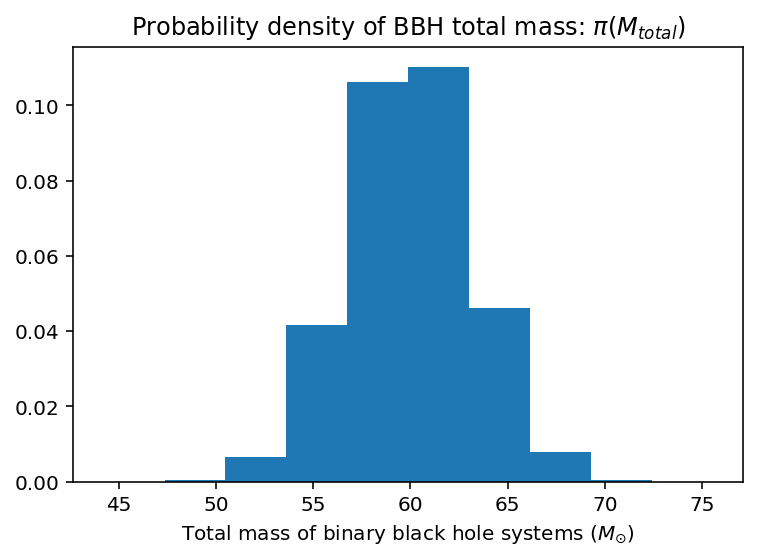

In [154]:
plt.hist(BBH_masses, density=True)
plt.xlabel(r"Total mass of binary black hole systems $(M_{\odot})$")
plt.title(r"Probability density of BBH total mass: $\pi(M_{total})$")
plt.show()

In [155]:
## bundle up our data, noise, masses into a pandas data frame 
_df = {'total mass':BBH_masses, 'strain_data':strain_data, 'noise':noise_measurements}
dataframe = pd.DataFrame(data=_df)

In [156]:
dataframe.round(1)

,total mass,strain_data,noise
0,68.0,-5.112977e-21+4.236115e-23j,7.795233e-24+1.053201e-23j
1,60.3,-4.357761e-21+2.390639e-23j,3.910406e-24+2.059480e-24j
2,59.9,-4.321599e-21+2.015893e-23j,6.647520e-24-1.310836e-24j
3,61.5,-4.480998e-21+1.893626e-23j,-4.260658e-24-4.235938e-24j
4,62.9,-4.608881e-21+3.066314e-23j,-5.396018e-24+5.973027e-24j
...,...,...,...
999995,62.9,-4.609847e-21+3.499628e-23j,-5.908883e-24+1.030061e-23j
999996,63.0,-4.616055e-21+2.511220e-23j,2.228580e-25+2.649565e-25j
999997,63.7,-4.693425e-21+3.022915e-23j,-8.270628e-24+4.522137e-24j
999998,60.5,-4.389606e-21+2.932851e-23j,-8.157846e-24+7.256901e-24j


In [172]:
strain_data_new = GW_detector_noise(1) + GW_signal(55)

In [173]:
precision = 22 #number of decimal places to round data

idx = np.where(np.around(strain_data,precision)==np.around(strain_data_new, precision))

In [174]:
# the part of the dataframe where the strain data equals the new data (to our set precision)
lookup_table = dataframe[dataframe.index.isin(idx[0])]

In [175]:
# this contains the total masses that produce strain data equal to what we just "measured"
# with this, we can estimate the probability of a the total mass given our newly measured data by counting  
lookup_table

,total mass,strain_data,noise
22,54.786153,-3.890579e-21+1.781288e-23j,-1.286307e-23+1.214534e-24j
68,54.588211,-3.853881e-21+3.277367e-23j,7.278896e-24+1.635010e-23j
70,55.092835,-3.911523e-21+1.393583e-23j,-8.048555e-24-2.934723e-24j
80,55.041296,-3.891173e-21+1.775803e-23j,7.963255e-24+9.333486e-25j
93,55.143726,-3.912777e-21+9.640165e-24j,-5.015653e-24-7.275737e-24j
...,...,...,...
999812,54.867109,-3.889502e-21+2.476495e-23j,-4.999247e-24+8.094903e-24j
999911,55.088567,-3.898445e-21+1.808605e-23j,4.669814e-24+1.219292e-24j
999919,54.670271,-3.866265e-21+1.006243e-23j,1.751731e-24-6.433522e-24j
999985,54.512740,-3.853607e-21+1.633506e-23j,1.255260e-24-2.205051e-26j


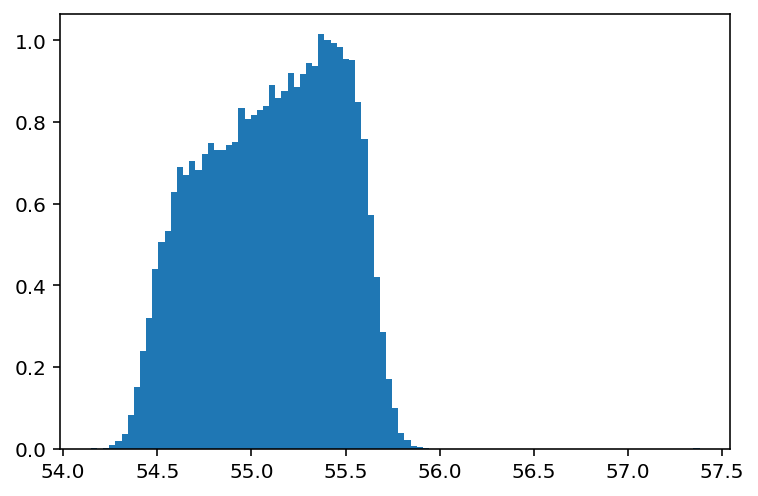

In [180]:
plt.hist(lookup_table['total mass'],density=True,bins='auto')
plt.show()

In [182]:
def lnL(d,mtotal):
  deltaF = 1/4.
  noise_mean = 0
  noise_var = lalsim.SimNoisePSDaLIGOZeroDetLowPower(150) / (4*deltaF)

  signal = GW_signal(mtotal)[0]
  return stats.norm.logpdf(d, loc=signal, scale=np.sqrt(noise_var))

def lnpi(mtotal):

  return 